In [2]:
import scipy as sp, numpy as np, matplotlib.pyplot as plt
from scipy.signal import max_len_seq, hilbert, decimate, medfilt, firwin, lfilter, spline_filter, gauss_spline
import random
from math import sin, pi, sqrt, tan, cos
from scipy.interpolate import interp1d
import zipfile

# Модели

In [44]:
class BOC:
    def __init__(self):
        pass
    def envelopSpectrum(self):
        pass

In [45]:
class BPSK:
    sin = np.sin
    pi = np.pi
    sqrt = np.sqrt

    def __init__(self, f_c, f):
        self.f_c = f_c
        self.f = f

    def gen_nav_message(self):
        self.len_nav_mes = 20 # длинна навигационного сообщения
        self.G_nm = [random.randint(0, 1) for _ in range(self.len_nav_mes)]
        self.G_nm_counts = [i for i in range(len(self.G_nm))]
    
    def gen_dk(self):
        self.len_dk = 1023 # длинна дальномерного кода
        self.G_dk = [random.randint(0, 1) for _ in range(self.len_dk)]
        self.G_dk_counts = [i for i in range(len(self.G_dk))]

    def plot_digital_seq(self):
        
        if self.G_dk is None or self.G_nm is None:
            raise Exception(f'Не сгенерированы навигационное сообщение и дальномерный код.\
                            Вызовите методы gen_nav_message и gen_dk')
        
        plt.figure(figsize=(10, 6))

        plt.subplot(2, 1, 1)
        plt.step(self.G_nm_counts, self.G_nm, where='mid')
        plt.xlabel('Номер отсчета')
        plt.ylabel('Значение отсчета')
        plt.title('Навигационное сообщение')
        plt.grid(axis='x')
        plt.xticks(ticks=self.G_nm_counts)
        plt.margins(x=0.1, y=0.1)


        plt.subplot(2, 1, 2)
        plt.step(self.G_dk_counts[:20], self.G_dk[:20], where='mid')
        plt.xlabel('Номер отсчета')
        plt.ylabel('Значение отсчета')
        plt.title('Дальномерный код(20 отсчетов)')
        plt.grid(axis='x')
        plt.xticks(ticks=self.G_dk_counts[:20])
        plt.margins(x=0.1, y=0.1)

        plt.subplots_adjust(hspace=1)
        plt.tight_layout()
        plt.show()

    def signal(self, duration):
        signalPowerDb = -158.5 #дБВт
        A = sqrt(10**(signalPowerDb/10))

        if duration < 1023e-6:
            raise Exception(f'Малая длительность сигнала.\
                            Увелите длительность')

        if self.G_dk is None or self.G_nm is None:
            raise Exception(f'Не сгенерированы навигационное сообщение и дальномерный код.\
                            Вызовите методы gen_nav_message и gen_dk')
        
        # как бы дублируем последовательности на длительность сигнала
        G_dk = np.tile(self.G_dk, int(duration/(self.len_dk*1e-6)))
        G_nm = np.tile(self.G_nm, int(duration/(self.len_nav_mes*1e-6)))
        
        # тут исходим из того, что 20 симовлов за 20 мс, следовательно минимальный шаг с которым гинериться ПСП 1 мс
        sample_rate = 1e-6/3 # частотта дискретизации даолжна быть меньше чем 1мс
        time = np.arange(0, duration, sample_rate)
        G_dk = np.repeat(G_dk, int(1e-6/sample_rate))
        G_nm = np.repeat(G_nm, int(1e-6/sample_rate))

        # выраниваем длины
        min_len = min(len(G_nm), len(G_dk), len(time))
        time = np.copy(time[:min_len])
        G_dk = np.copy(G_dk[:min_len])
        G_nm = np.copy(G_nm[:min_len])

        self.signal = A*G_dk*G_nm*self.sin(2*pi*self.f*time)
        return self.signal, time
    
    def envelopeSpectrumBPSK(self, f):
        return self.f_c*(np.sin(pi*f/self.f_c)**2/(pi*f/self.f_c)**2)  

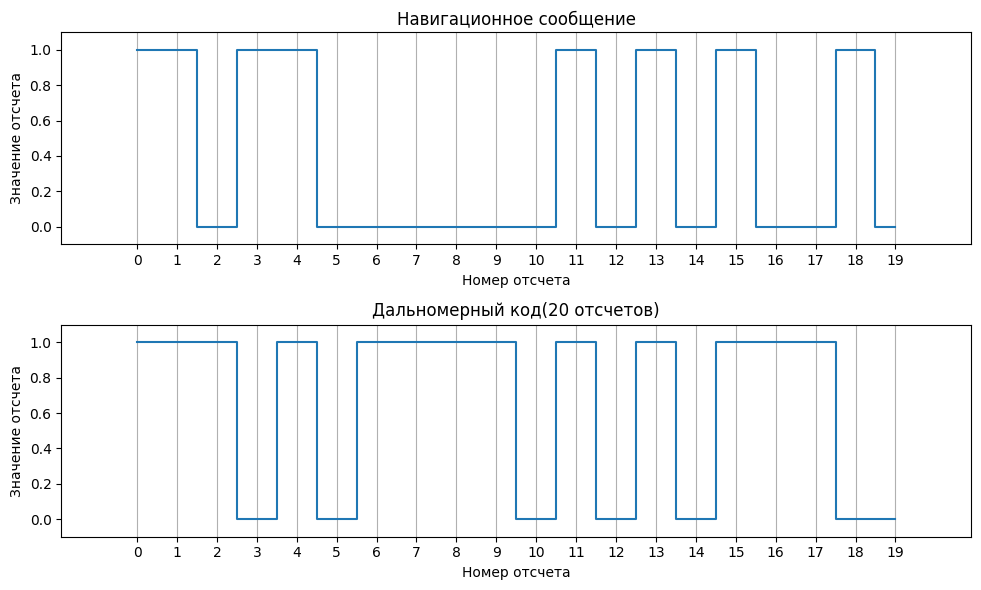

In [46]:
GPS_L1_CA = BPSK(1.023e6,1575.75e6)
GPS_L1_CA.gen_dk()
GPS_L1_CA.gen_nav_message()
GPS_L1_CA.plot_digital_seq()

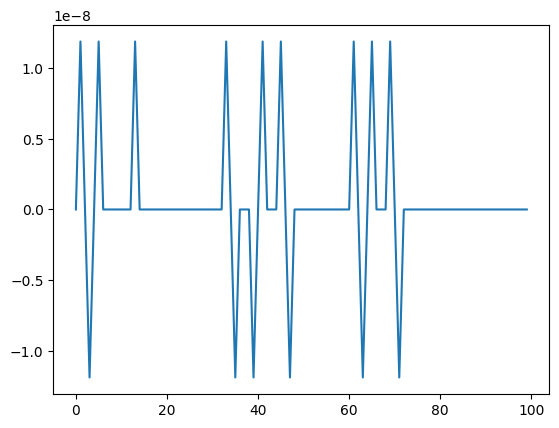

In [47]:
signal, time = GPS_L1_CA.signal(10e-3)
plt.plot(signal[:100])    

C:\Users\Asus\AppData\Local\Temp\ipykernel_10576\3665170570.py:83: RuntimeWarning: invalid value encountered in divide
  return self.f_c*(np.sin(pi*f/self.f_c)**2/(pi*f/self.f_c)**2)


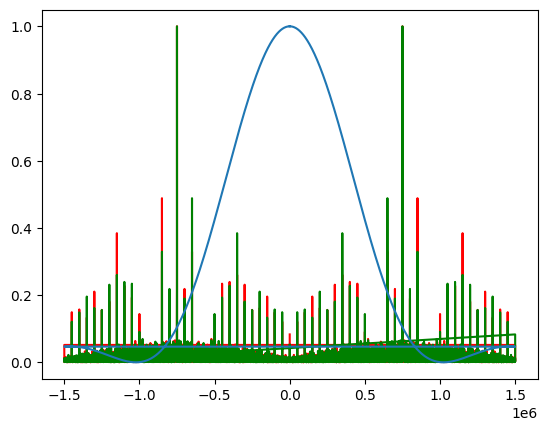

In [48]:
fft_signal = np.fft.fft(signal)
norm_fft_signal = np.abs(fft_signal)/np.max(np.abs(fft_signal))
fft_signal_shift = np.fft.fftshift(norm_fft_signal)

freq = np.fft.fftfreq(len(signal), d=time[1] - time[0])
envelop_fft = GPS_L1_CA.envelopeSpectrumBPSK(freq)
mask = ~np.isnan(envelop_fft)
norm_envelop_fft = envelop_fft[mask]/np.max(envelop_fft[mask])

# строим график спектра
plt.plot(freq, norm_fft_signal, "r")
plt.plot(freq, fft_signal_shift, "g")
plt.plot(freq[mask], norm_envelop_fft)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()


In [49]:
def addNoise(signal):
    noise = np.random.normal(0, 1, len(signal))
    print(noise)
    return signal * noise

    

[-0.2431139  -0.3063231  -1.27873597 ...  0.86214255  0.43806534
  0.06748988]


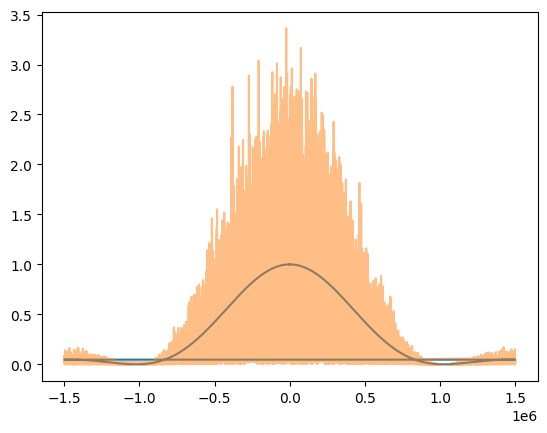

In [50]:
# строим график спектра
fft_noised = np.abs(addNoise(norm_envelop_fft))
plt.plot(freq[mask], norm_envelop_fft)
plt.plot(freq[mask], fft_noised, alpha=0.5)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

## BOC

__GPS L1C__
* sinBOC
* m = 1 = f_s/f_ref
* n = 1 = f_c/f_ref

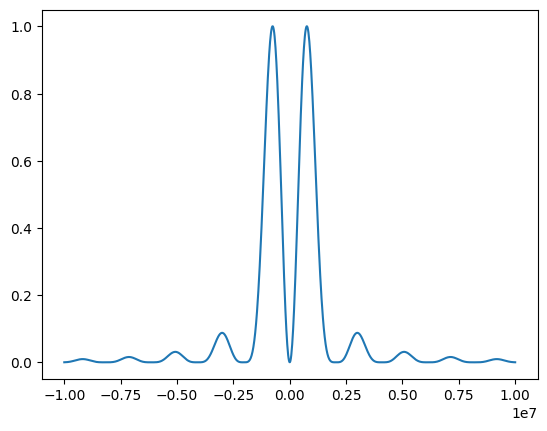

In [51]:
f = np.linspace(-int(10e6), int(10e6), int(1e3))
m = 1
n = 1
f_c = 1.023e6
f_s = 1.023e6
G_sin = 1/f_c*np.sin(np.pi*f/f_c)**2/(np.pi*f/f_c)**2*np.tan(np.pi*f/(2*f_s))**2
G_cos = 1/f_c*np.cos(pi*f/f_c)**2/(np.pi*f/f_c)**2*np.tan(np.pi*f/(2*f_s))**2

G_sin_norm = np.abs(G_sin)/np.max(G_sin)
G_cos_norm = np.abs(G_cos)/np.max(G_cos)

G_sin_db = 10*np.log10(G_sin_norm)
G_cos_db = 10*np.log10(G_cos_norm)

plt.plot(f, G_sin_norm, label="sinBOC(1,1)")
# plt.plot(f, G_cos_norm, label="cosBOC(1,1)")

# Анализ спектра

In [52]:
from scipy.signal import find_peaks, peak_widths
from scipy.spatial.distance import pdist, squareform

In [53]:
border = 0
left_spectrum_part = f < border
right_spectrum_part = f >= border
# дальнейшие вычисления аналогичны и для левой и парвой частей
spectrum = G_sin_db[left_spectrum_part]
peaks, _ = find_peaks(spectrum, distance=3)
wight_peaks = peak_widths(spectrum, peaks)
main_peak_index = np.argmax(spectrum[peaks])
main_peak = peaks[main_peak_index]
# main_peak_width = props['peak_width_right']
secondary_peak_index = np.argmax(np.delete(spectrum[peaks], main_peak_index))
secondary_peak = peaks[secondary_peak_index]
print(f"главный максимум: {main_peak}, {spectrum[main_peak]}")
print(f"побочный максимум: {secondary_peak}, {spectrum[secondary_peak]}")


главный максимум: 462, 0.0
побочный максимум: 350, -10.566514740107309


In [54]:
len(wight_peaks), len(peaks)

(4, 5)

(-50.0, 5.92087052330551)

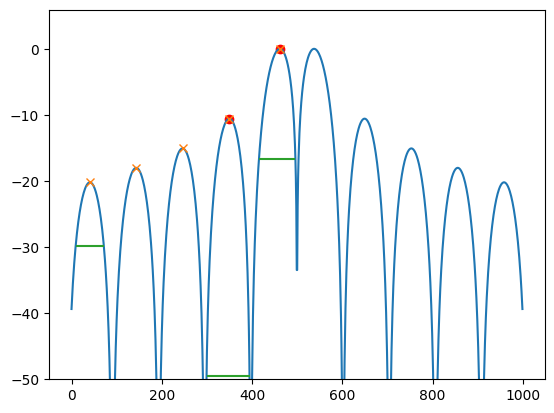

In [55]:
plt.plot(G_sin_db)
plt.plot(peaks, G_sin_db[peaks], "x")
plt.scatter([main_peak, secondary_peak],[spectrum[main_peak],spectrum[secondary_peak]] ,color='red')
plt.hlines(*wight_peaks[1:], color="C2")
plt.ylim(-50)

In [56]:
# для расчета 
main_peak_width_level = main_peak - 3
# secondary_peak_width_level = secondary_peak - 3
with_elem_1 = np.argmin(np.abs(spectrum - main_peak_width_level))
with_elem_2 = np.argmin(np.abs(np.delete(spectrum,with_elem_1) - main_peak_width_level))
print(f"ширина главного максимума: {abs(with_elem_1 - with_elem_2)}")

ширина главного максимума: 1


## Классы для анализа спектра

In [57]:
from abc import ABC, abstractmethod

In [58]:
class SpectrumAnalizer(ABC):
    def __init__(self, spectrum = None, freq = None):
        
        self.__freq = freq
        self.__spectrum = spectrum/np.max(spectrum)

        self.__main_peak = []
        self.__wigth__main_peak = []

        self.__second_peak = []
        self.__wigth__second_peak = []

    @property
    def spectrum(self):
        return self.__spectrum
    
    @property
    def dBspectrum(self):
        return 10*np.log10(self.__spectrum)

    @spectrum.setter
    def spectrum(self, spectrum):
        self.__spectrum = spectrum/np.max(spectrum)

    @property
    def freq(self):
        return self.__freq

    @freq.setter
    def freq(self, freq):
        self.__freq = freq

    @abstractmethod
    def peaks(self):
        pass
    
    @abstractmethod
    def width_peaks(self):
        pass    


In [59]:
class ScipyAnalizer(SpectrumAnalizer):
    def __init__(self, spectrum, freq):
        super().__init__(spectrum=spectrum, freq=freq)
        self.__border = None
    
    @property
    def border(self):
        return self.__border
    
    @border.setter
    def border(self, border):
        self.__border = border
    
    def peaks(self):
        left_freq_part = self.__freq < self.__border
        right_freq_part = self.__freq >= self.__border
        
        left_spectrum_part = self.__spectrum[left_freq_part]
        right_spectrum_part = self.__spectrum[right_freq_part]
        
        left_peaks = self.__peakPartCount(left_spectrum_part)
        right_peaks = self.__peakPartCount(right_spectrum_part)
        
        self.__main_peak.append(left_peaks.main_peak)
        self.__main_peak.append(right_peaks.main_peak)

        self.__second_peak.append(left_peaks.secondary_peak)
        self.__second_peak.append(right_peaks.secondary_peak)

        return {
            main_peak: self.__main_peak,
            secondary_peak: self.__second_peak,
        }

    def __peakPartCount(self, spectrum):
        distance = 3
        peaks, _ = find_peaks(spectrum, distance=distance)

        main_peak_index = np.argmax(spectrum[peaks])
        main_peak = peaks[main_peak_index]
        
        secondary_peak_index = np.argmax(np.delete(spectrum[peaks], main_peak_index))
        secondary_peak = peaks[secondary_peak_index]

        print(f"главный максимум: {main_peak}, {spectrum[main_peak]}")
        print(f"побочный максимум: {secondary_peak}, {spectrum[secondary_peak]}")

        return {
            main_peak: main_peak,
            secondary_peak: secondary_peak,
        }
    
    def width_peaks(self):
        wigth__main_peak = peak_widths(self.__spectrum, self.__wigth__main_peak)
        wigth__second_peak = peak_widths(self.__spectrum, self.__wigth__second_peak)

        return {
            wigth__main_peak: wigth__main_peak,
            wigth__second_peak: wigth__second_peak,
        }

# Тестирование на данных

In [ ]:
with zipfile.ZipFile('datasets\gpsMax.zip', 'r') as zip_ref:
    zip_ref.extractall('datasets')

PermissionError: [Errno 13] Permission denied: 'datasets\\gpsMax.bin'

In [3]:
with open('datasets\gpsMax.bin\gpsMax.bin', 'r') as file:
    data = file.read()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x98 in position 168: character maps to <undefined>

In [3]:
# file_path = '.\datasets\gps10.bin'
file_path = 'datasets\gpsMax.bin\gpsMax.bin'

data = np.fromfile(file_path, dtype=np.int16)

In [4]:
I = data[0::2]
Q = data[1::2]  

print("I компоненты:", I)
print("Q компоненты:", Q)
print("размер выборок:", len(Q))

I компоненты: [350 350  45 ... 514 698 151]
Q компоненты: [   3   -3    1 ...   86 -198 -428]
размер выборок: 779740000


In [5]:
signal = np.empty(len(I), np.complex64)

In [ ]:
# signal = I + 1j * Q
signal = [complex(I[i], Q[i]) for i in range(len(signal))]
print('Размер сигнала: ', len(signal), 'Четность: ', len(signal) % 2 == 0)

In [ ]:
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal))
magnitude = np.abs(fft_result)

Размер сигнала:  25740000 Четность:  True


In [4]:
print(len(magnitude))

25740000


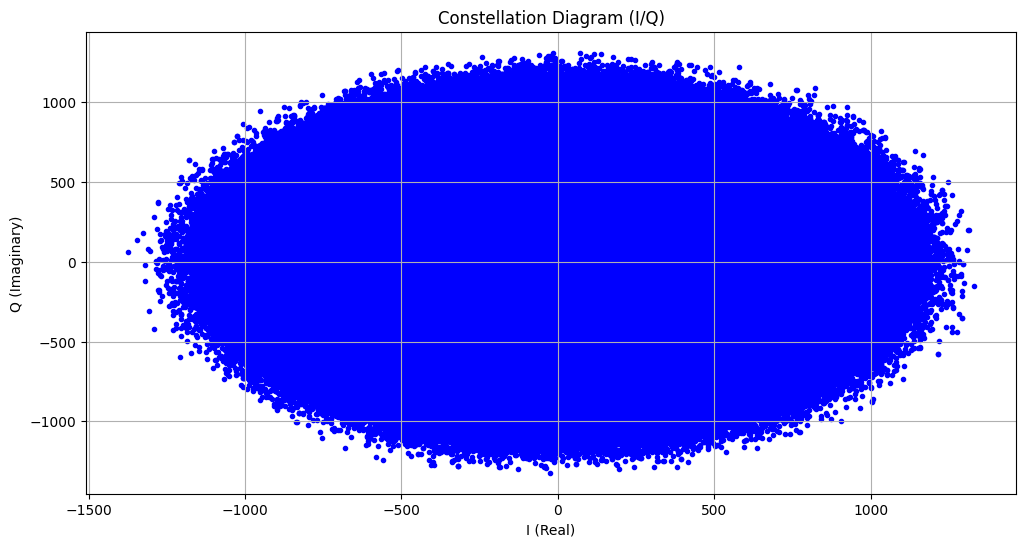

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(I, Q, marker='.', color='b')
plt.xlabel('I (Real)')
plt.ylabel('Q (Imaginary)')
plt.title('Constellation Diagram (I/Q)')
plt.grid()
# plt.xlim(0, 0.5) 
plt.show()

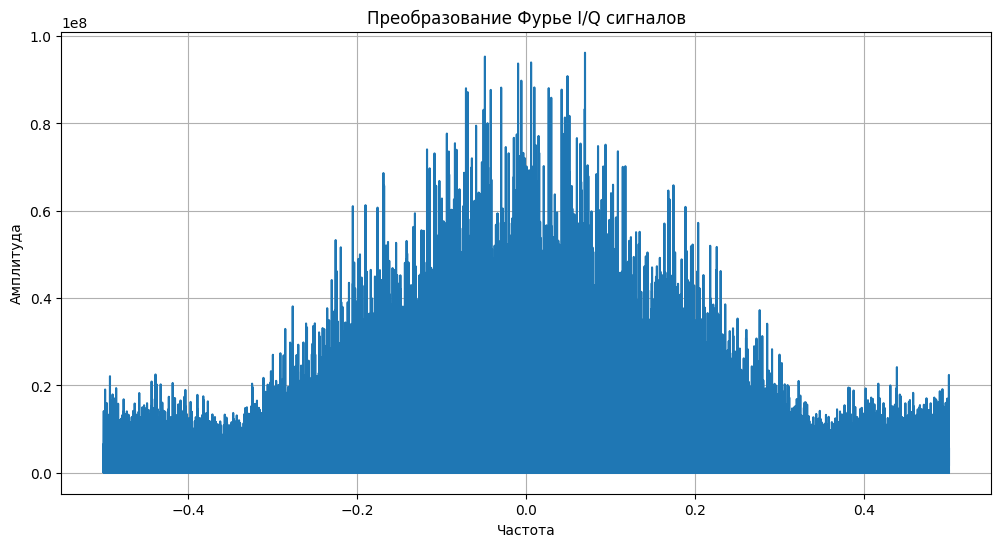

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(frequencies, magnitude)
plt.title('Преобразование Фурье I/Q сигналов')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.grid()
# plt.xlim(0, 0.5) 
plt.show()

In [12]:
envelope = medfilt(magnitude, 15)

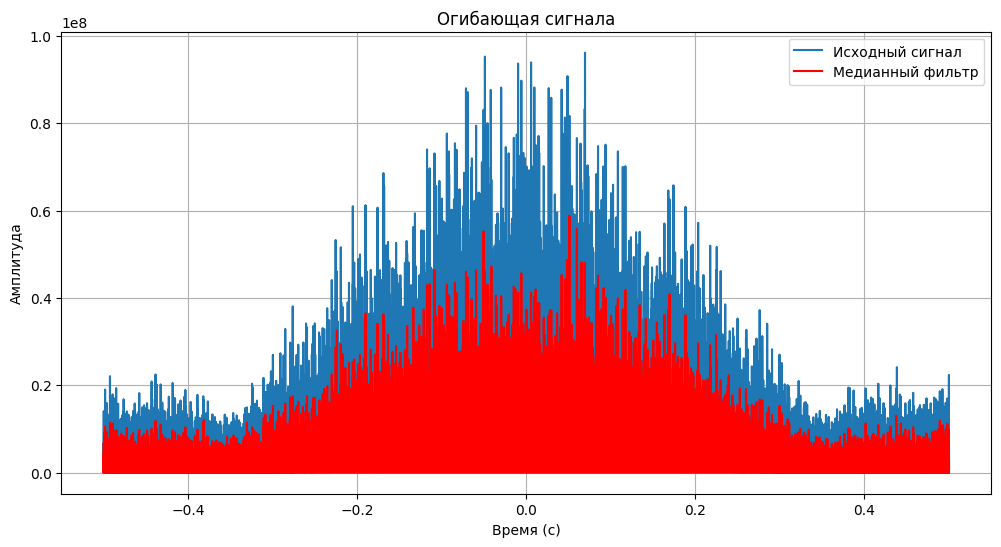

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(frequencies, magnitude, label='Исходный сигнал')
plt.plot(frequencies, envelope, label='Медианный фильтр', color='red')
plt.title('Огибающая сигнала')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid()
# plt.xlim(0, 0.5) 
plt.show()

In [90]:
# Параметры FIR-фильтра
numtaps = 21  # Порядок фильтра (должен быть нечетным)
cutoff = 0.1  # Нормализованная частота среза (0.1 = 10% от частоты Найквиста)

# Расчет коэффициентов FIR-фильтра
fir_coeff = firwin(numtaps, cutoff, window="hamming")

# Применение фильтра к сигналу
filtered_signal = lfilter(fir_coeff, 1.0, magnitude)

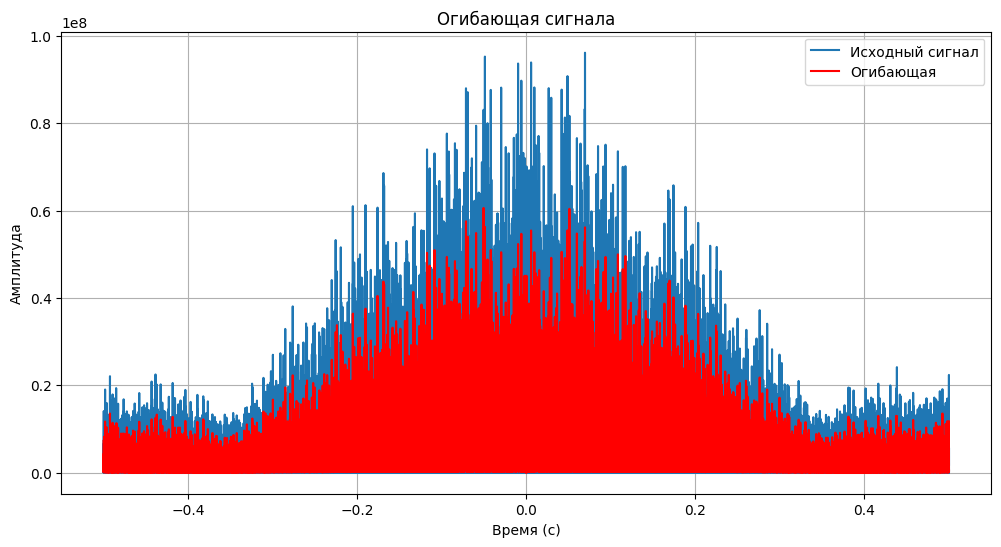

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(frequencies, magnitude, label='Исходный сигнал')
plt.plot(frequencies, filtered_signal, label='FIR', color='red')
plt.title('Огибающая сигнала')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid()
# plt.xlim(0, 0.5) 
plt.show()

In [98]:
hilberted__signal = hilbert(magnitude)

c:\Users\Asus\Documents\ВУЗ\12 семестр\Диплом\Обработка\libs\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


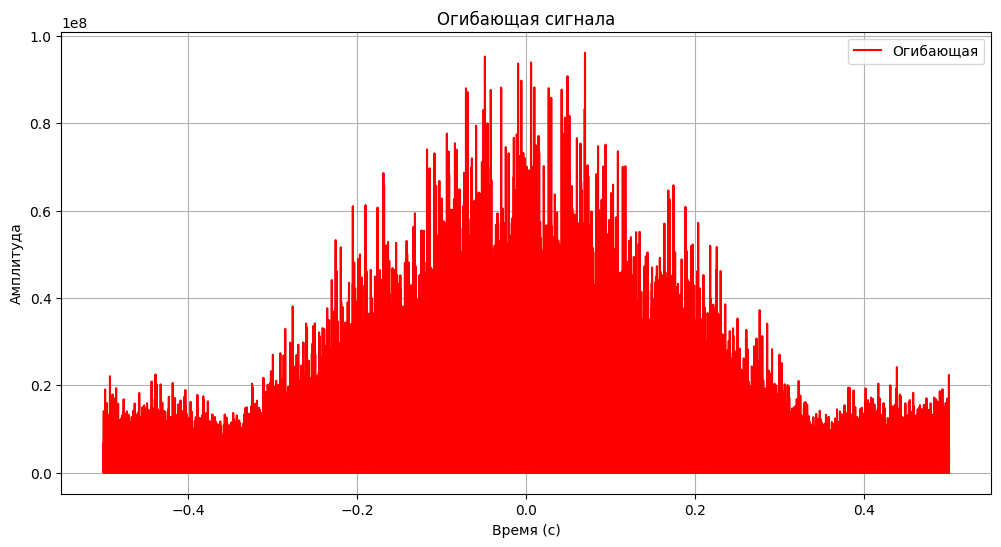

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(frequencies, magnitude, label='Исходный сигнал')
plt.plot(frequencies, hilberted__signal, label='Гильберт', color='red')
plt.title('Огибающая сигнала')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid()
# plt.xlim(0, 0.5) 
plt.show()

In [108]:
spline__signal = gauss_spline(magnitude, 0.1)

__Таблицы данных по ГНСС__
<img src='./img/GPStable.png'>